# Nepali Sentiment analysis with transformer architecture


In [1]:
%pip install --quiet gensim nltk optuna seaborn torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pickle
import gensim
from gensim.models import Word2Vec

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
os.chdir("../../..")
from src.utils.visualization import plot_sentiment_distribution

In [4]:
df = pd.read_csv(
    'dataset/processed/combined_sentiment_dataset.csv', encoding='utf-8')
df.head()

,Sentences,Sentiment
0,पुन निर्वाचन गरे यस्तै हुने हो निर्वाचन कति गर...,0
1,क्या अचम्मकाे नगरपालिका डाेजरम्यान बालेनकाे,0
2,प्युठान नगरपालिका नेपाल स्वयंसेवक राष्ट्रिय सम...,0
3,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले पाए...,0
4,कपिलवस्तुको शिवराज नगरपालिका का बासिन्दाले वर्...,0


In [5]:
df.shape

(40708, 2)

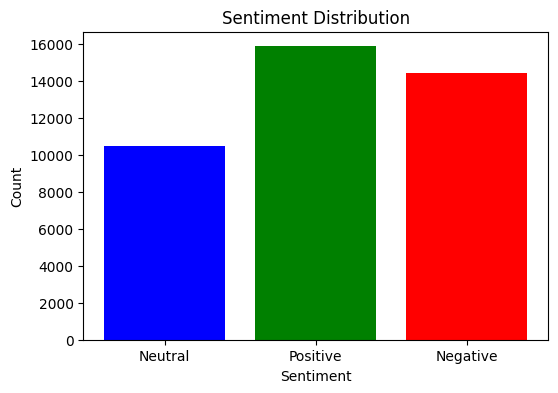

In [6]:
labels_dict = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}

plot_sentiment_distribution(
    df, 'Sentiment Distribution', labels_dict
)

In [7]:
df = df[df['Sentiment'] != 0]
df = df.reset_index(drop=True)

df['Sentiment'] = df['Sentiment'].replace(2, 0)
df['Sentiment'].value_counts()

Sentiment
1    15857
0    14393
Name: count, dtype: int64

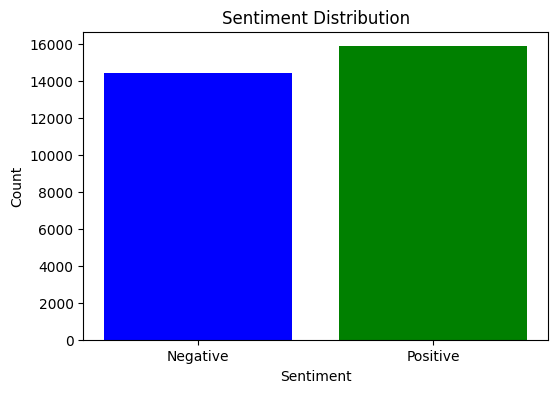

In [8]:
labels_dict = {0: 'Negative', 1: 'Positive'}

plot_sentiment_distribution(
    df, 'Sentiment Distribution', labels_dict
)

### Preprocessing


In [9]:
df.sample(5)

,Sentences,Sentiment
9953,रक्षाबन्धन जनै पूर्णिमा राखी विविध स्वरूपमा सा...,1
24967,निजी अस्पतालमा कोभिड का बिरामीको उपचार व्यवस्थ...,1
15440,नरैनापुरकै प्राथमिक स्वास्थ्य केन्द्रमा आइसोले...,1
28181,कोभिड शंका लागेमा नमूना परीक्षणका लागि राष्ट्र...,1
16933,विश्व नै कोभिड सँग जुधिरहेको संकटकालीन अवस्थाम...,0


In [10]:
df['review_length'] = df['Sentences'].apply(len)
average_review_length = df['review_length'].mean()

print(f"Average length of reviews: {average_review_length}")

Average length of reviews: 113.0764958677686


### Tokenization


In [11]:
from src.utils.preprocessing import tokenizer

In [12]:
sentences = [item for item in df['Sentences']]
sentiments = [item for item in df['Sentiment']]

tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

In [13]:
import os
from gensim.models import KeyedVectors

# Load pre-trained Word2Vec model from the file
word2vec_model_path = 'dataset/nepali_embeddings_word2vec.txt'

# If you have saved the model in a pickle file before, load from pickle for faster loading
embedding_model_file = 'src/models/nepali_word2vec_model.pkl'

# Check if pickle file exists to load the embeddings faster
if os.path.exists(embedding_model_file):
    print("Found")
    with open(embedding_model_file, 'rb') as f:
        word2vec_model = pickle.load(f)
else:
    # Load Word2Vec model if pickle file doesn't exist
    word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(
        word2vec_model_path, binary=False)
    # Save the model for future use
    with open(embedding_model_file, 'wb') as f:
        pickle.dump(word2vec_model, f)

Found


In [14]:
# Convert each token to its word2vec embedding
max_length = 32

embedded_reviews = []

for tokens in tokenized_sentences:
    review_vector = []
    for token in tokens:
        if token in word2vec_model:
            review_vector.append(word2vec_model[token])
        else:
            # If token not found, use a zero vector
            review_vector.append(np.zeros(word2vec_model.vector_size))

    # Pad the review to max_length with zero vectors
    if len(review_vector) > max_length:
        review_vector = review_vector[:max_length]
    else:
        review_vector.extend(
            [np.zeros(word2vec_model.vector_size)] * (max_length - len(review_vector)))

    embedded_reviews.append(review_vector)

In [15]:
embedded_reviews_array = np.array(embedded_reviews)
embedded_reviews_array.shape

(30250, 32, 300)

## Transformer Model


In [16]:
from src.models.transformer_binary import NepaliSentimentBinaryModel

In [17]:
# # Parameters
# d_model = 300
# num_heads = 4
# num_layers = 2
# num_classes = 2

# d_ff = 600
# max_len = max_length
# dropout = 0.1

# Parameters
d_model = 300      # Embedding size (reasonable for most tasks)
num_heads = 6      # Number of attention heads (divides d_model evenly)
# Number of transformer layers (balance between depth and efficiency)
num_layers = 4
num_classes = 2    # Sentiment classification (positive/negative)

d_ff = 60        # Feedforward layer size (2-4 times d_model for more capacity)
# Max sequence length (adjust based on input text length)
max_len = max_length
# Dropout rate (balance between overfitting and underfitting)
dropout = 0.1

- num_heads = 6 divides d_model evenly, improving attention mechanism efficiency.
- num_layers = 4 provides a deeper model, allowing it to learn more complex patterns.
- d_ff = 1024 provides a sufficient capacity for the feedforward network, allowing the model to learn richer transformations.
- max_len = 256 is a middle ground that can handle most sequences without requiring excessive memory.
- dropout = 0.1 keeps the model regularized while avoiding overfitting, but you can adjust it based on performance.


In [ ]:
model = NepaliSentimentBinaryModel(
    d_model, num_heads, num_layers, d_ff, max_len, dropout
)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [ ]:
sentiments_tensor = torch.tensor(sentiments, dtype=torch.long)
embedded_reviews_tensor = torch.tensor(
    embedded_reviews_array, 
    dtype=torch.float32
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
model = model.to(device)

In [ ]:
# Shape: (30150, 32, 300)
X = torch.tensor(embedded_reviews_array, dtype=torch.float32)
y = torch.tensor(sentiments, dtype=torch.long)  # Shape: (30150,)

print(f"Shape of X: {X.shape}")

In [ ]:
# First, split into training and temp (validation + test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [ ]:
# Then, split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Convert to DataLoader for batch processing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
# Early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=2, factor=0.5)

In [ ]:
# Training and evaluation function
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = len(loader.dataset)
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # For multiclass
            all_labels.extend(labels.view(-1).cpu().numpy())
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(
        all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    return accuracy, f1, precision, recall

In [ ]:
print(f"Outputs shape: {outputs.shape}, Labels shape: {labels.shape}")


In [ ]:
num_epochs = 20

# Tracking metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()

         # Compute loss

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.view(-1), labels)  # Flatten outputs to match label shape

        # Backward pass
        loss.backward()
        optimizer.step()

         # Track loss and accuracy
        running_loss += loss.item()
        predictions = (torch.sigmoid(outputs.view(-1)) > 0.5).long()  # Binary predictions
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = running_loss / len(train_loader)  # Average training loss
    train_accuracy = 100 * correct_predictions / total_predictions

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val_predictions += (predicted == labels).sum().item()
            total_val_predictions += labels.size(0)

            # Store true and predicted labels for confusion matrix
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader)  # Average validation loss
    val_accuracy = 100 * correct_val_predictions / total_val_predictions

    # Append metrics to lists for tracking
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping and learning rate scheduling
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), "best_model.pth")  # Save the best model
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:  # Early stopping condition
        print("Early stopping triggered.")
        break

In [ ]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test set
test_accuracy, test_f1, test_precision, test_recall = evaluate(
    model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1 Score: {test_f1:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels,
      target_names=['Positive', 'Negative']
      ))

In [ ]:
with open('src/models/outputs/binary_transformer.pkl', 'wb') as f:
    pickle.dump(model, f)